As with all techniques, ZNE is compatible with any frontend supported by Mitiq:



# Probabilistic Error Cancellation(PEC)

In [1]:
import mitiq
mitiq.SUPPORTED_PROGRAM_TYPES.keys()

['braket', 'cirq', 'pennylane', 'pyquil', 'qibo', 'qiskit']

Select front end 

In [2]:
frontend = "qiskit"

Importing Qiskit packages

In [3]:
import qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler, Estimator, Session, QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
import pdb

# IBMProvider.save_account(token='bd93da0511f5a9af4510ba43068307e9bed56d16c9e90cb216c5973a5f8b423f5eeeff26d0d899f5210e1240e33a7080b718d1c4677c4e6f659895bfe0331fde', overwrite=True)
provider = QiskitRuntimeService()


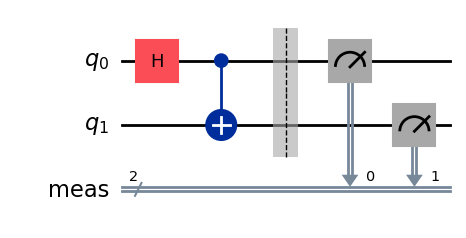

In [61]:


num_qubits = 2
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
display(qc.draw('mpl'))


def ibmq_circuit_executor(qc: qiskit.QuantumCircuit, num_shots: int=1024)->float:
    # backend_name = provider.get_backend(machine_name)
    backend = AerSimulator(method='statevector')      
    qc = transpile(qc, backend)
    job = backend.run(circuits=qc, shots = num_shots)
    counts = job.result().get_counts() 

    total_shots = sum(counts.values())
    total_z_expectation = 0
    for bitstring, count in counts.items():
        probability = count / total_shots
        z_expectation = 1  # Start with product of +1 for the whole system
        
        # Loop through each qubit in the bitstring
        for i in range(len(bitstring)):
            if bitstring[i] == '0':
                z_expectation *= 1  # |0⟩ -> +1
            else:
                z_expectation *= -1  # |1⟩ -> -1

        # Add the contribution to the total expectation value
        total_z_expectation += probability * z_expectation
    return total_z_expectation




def ibmq_circuit_executor_noisy(qc: qiskit.QuantumCircuit, machine_name: str='ibm_cleveland', num_shots: int=1024)->float:
    backend_name = provider.get_backend(machine_name)
    backend = AerSimulator(method='statevector').from_backend(backend_name)       
    qc = transpile(qc, backend)
    job = backend.run(circuits=qc, shots = num_shots)
    counts = job.result().get_counts() 

    total_shots = sum(counts.values())
    total_z_expectation = 0
    for bitstring, count in counts.items():
        probability = count / total_shots
        z_expectation = 1  # Start with product of +1 for the whole system
        
        # Loop through each qubit in the bitstring
        for i in range(len(bitstring)):
            if bitstring[i] == '0':
                z_expectation *= 1  # |0⟩ -> +1
            else:
                z_expectation *= -1  # |1⟩ -> -1

        # Add the contribution to the total expectation value
        total_z_expectation += probability * z_expectation
    return total_z_expectation



# ideal_expectation = ibmq_circuit_executor(qc)
# unmitigated_expectation_noisy = ibmq_circuit_executor_noisy(qc)
# mitigated_expectation = zne.execute_with_zne(qc, ibmq_circuit_executor_noisy)
# print("Ideal Expectation :", ideal_expectation)
# print("Unmitigated :", unmitigated_expectation_noisy)
# print("Mitigated :", mitigated_expectation)


 
     

In [9]:
machine_name = 'ibm_cleveland'
backend_name = provider.get_backend(machine_name)
backend = AerSimulator(method='statevector').from_backend(backend_name)  

In [18]:
type(backend)

qiskit_aer.backends.aer_simulator.AerSimulator

# With Probabilistic Error Cancellation
### Build quasi-probability representation for CNOT gate

In [60]:
from mitiq import pec

For simplicity, we assume that:
    
* Only CNOT gates are affected by noise;
* The noise is depolarizing.

Even within these assumptions, we still need to know how strong the noise is. A good approximation is the error probability of the CNOT gate.

In [56]:
x_gate_error_prob = backend.properties().gate_error(gate="x", qubits=(0))
x_gate_error_prob

0.00017165367628356302

We now build a quasi-probability representation based on the previous assumptions. I.e., we represent the ideal X gate as a linear combination of noisy operations:

$$ \mathcal G_{\rm X} = \sum_\alpha \eta_\alpha \mathcal O_\alpha, \quad \eta_\alpha \in \mathbb R, \quad \{ \mathcal O_\alpha \} = \text{Noisy implementable operations}.$$

In [63]:
# from mitiq.pec.representations.depolarizing import represent_operation_with_global_depolarizing_noise

# # Define ideal operation that we aim to represent
# x_circuit = qiskit.QuantumCircuit(qiskit.QuantumRegister(2, name="q")) 
# x_circuit.x(0)

# # Build representation
# x_rep = represent_operation_with_global_depolarizing_noise(x_circuit, noise_level=x_gate_error_prob)

# print(f"Quasi-probability representation with one-norm {x_rep.norm :g} generated.")
# # print(cnot_rep)

Run PEC

In [64]:
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

noise_level = 0.01
reps = represent_operations_in_circuit_with_local_depolarizing_noise(qc, noise_level)
print(f"{len(reps)} OperationRepresentation objects produced, assuming {100 * noise_level}% depolarizing noise.")

2 OperationRepresentation objects produced, assuming 1.0% depolarizing noise.


In [65]:
print(reps[0])


q_0: ───@───
        │
q_1: ───X─── = 

1.020
q_0: ───@───
        │
q_1: ───X───

-0.003
q_0: ───@───X───
        │
q_1: ───X───────

-0.003
q_0: ───@───Y───
        │
q_1: ───X───────

-0.003
q_0: ───@───Z───
        │
q_1: ───X───────

-0.003
q_0: ───@───────
        │
q_1: ───X───X───

-0.003
q_0: ───@───────
        │
q_1: ───X───Y───

-0.003
q_0: ───@───────
        │
q_1: ───X───Z───
